In [1]:
!pip install ../input/mtcnn-package/mtcnn-0.1.0-py3-none-any.whl
  

Processing /kaggle/input/mtcnn-package/mtcnn-0.1.0-py3-none-any.whl


# Import Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import random
import glob
import keras
import cv2
from keras import Model,Sequential
from keras.layers import *
from keras.optimizers import *
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm # python process bar
from mtcnn import MTCNN
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop


Using TensorFlow backend.


# Load Train Data

In [3]:
# read in data
sorted(glob.glob('../input/deepfake/meta*'))
df_train = []
df_validation = []
for i in range(0, 40):
    cur_path = '../input/deepfake/metadata' + str(i) + '.json'
    #print(cur_path)
    cur_df = pd.read_json(cur_path)
    df_train.append(cur_df)
for j in range(40, 45):
    cur_path = '../input/deepfake/metadata' + str(j) + '.json'
    #print(cur_path)
    cur_df = pd.read_json(cur_path)
    df_validation.append(cur_df)


In [4]:
def read_image_from_df(x, y, dfs, nums):
    labels = ['REAL', 'FAKE']
    def read_image(image_num, image):
        if len(str(image_num)) == 1:
            path = '../input/deepfake/DeepFake0'+str(image_num)+'/DeepFake0'+str(image_num)+'/' + image.replace('.mp4', '.jpg')
        else:
            path = '../input/deepfake/DeepFake'+str(image_num)+'/DeepFake'+str(image_num)+'/' + image.replace('.mp4', '.jpg')
        if os.path.exists(path):
            return path
    paths = []
    for cur_df, num in tqdm(zip(dfs, nums), total = len(dfs)):
        images = list(cur_df.columns.values)
        for image in images:
            path = read_image(num, image)
            try:
                x.append(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))
                y.append(labels.index(cur_df[image]['label']))
                #print(labels.index(dfs[image]['label']))
            except Exception as err:
                pass
    return x, y
nums_train = list(range(len(df_train)))
nums_val = [i for i in range(40, 45)]
x, y = read_image_from_df([], [], df_train, nums_train)
x_val, y_val = read_image_from_df([], [], df_validation, nums_val)

In [ ]:
print(len(y))
print(len(y_val))

# Handling Underbalancing 

In [5]:
def balance_df(x, y):
    real=[]
    fake=[]
    for df,label in zip(x,y):
        if label == 0:
            real.append(df)
        else:
            fake.append(df)
 
    fake=random.sample(fake, len(real))
    x, y = [], []
    for df in real:
        x.append(df)
        y.append(0)
    for df in fake:
        x.append(df)
        y.append(1)
    return x, y
x,y = balance_df(x, y)
x_val, y_val = balance_df(x_val, y_val)
print('Fake train samples:' +  str(y.count(1)))
print('Real train samples:' +  str(y.count(0)))
print('Fake validation samples:' +  str(y_val.count(1)))
print('Real validation samples:' +  str(y_val.count(0)))

Fake train samples:14143
Real train samples:14143
Fake validation samples:2093
Real validation samples:2093


In [8]:
train_x,val_x,train_y,val_y = train_test_split(x, y, test_size=0.3,shuffle=True)

In [6]:
def define_model():
    model = Sequential(
        [
            Conv2D(16, (3, 3), padding="same", activation = 'relu', input_shape=(150, 150,3)),
            BatchNormalization(),
            MaxPooling2D(2, 2),
            Conv2D(32, (5, 5), padding="same", activation = 'relu'),
            BatchNormalization(),
            MaxPooling2D(2, 2),
            Conv2D(32, (5, 5), padding="same", activation = 'relu'),
            BatchNormalization(),
            MaxPooling2D(2, 2),
            Conv2D(32, (5, 5), padding="same", activation = 'relu'),
            BatchNormalization(),
            MaxPooling2D(4, 4),
            Flatten(),
            Dropout(0.25),
            Dense(16,activation='relu'),
            Dropout(0.25),
            Dense(1, activation="sigmoid"),
        ]
    )
    # Define the optimizer
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model
 

This model is the same as MesoNet.

# Train Model

In [18]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

# Training hyperparameters
epochs = 60
batch_size = 15

model=define_model()
result = model.fit([train_x], [train_y], batch_size = batch_size, epochs = epochs , verbose = 1,
                    callbacks=[learning_rate_reduction])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
batch_normalization_13 (Batc (None, 150, 150, 16)      64        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 75, 75, 32)        12832     
_________________________________________________________________
batch_normalization_14 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 37, 37, 32)       

19800/19800 [==============================] - 25s 1ms/step - loss: 0.1255 - accuracy: 0.9519
Epoch 54/60
19800/19800 [==============================] - 25s 1ms/step - loss: 0.1137 - accuracy: 0.9557
Epoch 55/60
19800/19800 [==============================] - 26s 1ms/step - loss: 0.1151 - accuracy: 0.9550
Epoch 56/60
19800/19800 [==============================] - 25s 1ms/step - loss: 0.1160 - accuracy: 0.9564
Epoch 57/60
19800/19800 [==============================] - 26s 1ms/step - loss: 0.1121 - accuracy: 0.9581
Epoch 58/60
19800/19800 [==============================] - 25s 1ms/step - loss: 0.1077 - accuracy: 0.9588
Epoch 59/60
19800/19800 [==============================] - 26s 1ms/step - loss: 0.1101 - accuracy: 0.9580
Epoch 60/60
19800/19800 [==============================] - 26s 1ms/step - loss: 0.1085 - accuracy: 0.9587

Epoch 00060: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


Text(0.5, 0, 'Epoch')

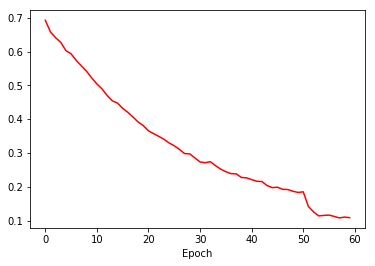

In [21]:
import matplotlib.pyplot as plt
plt.plot(result.history["loss"], color='red')
#plt.plot(result.history["val_loss"])
#plt.plot(result.history["accuracy"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(labels=["train", "val"])

Text(0.5, 0, 'Accuracy')

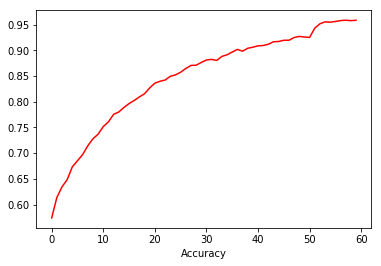

In [20]:
import matplotlib.pyplot as plt
#plt.plot(result.history["loss"])
#plt.plot(result.history["val_loss"])
plt.plot(result.history["accuracy"], color='red')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

In [16]:
labels = ['REAL', 'FAKE']
target_val = [labels[i] for i in val_y]
prediction = model.predict([val_x])
print('model loss for validation data: '+ str(log_loss(target_val,prediction.clip(0.1,0.9))))
print(prediction.mean())
print(prediction[:5])


model loss for validation data: 1.5963796140512374
0.37169003
[[5.9604645e-08]
 [3.2477784e-01]
 [1.7387491e-01]
 [9.9686164e-01]
 [7.5269103e-01]]


In [ ]:
model.save('model.h5')

# Using Model for Video Test Data

In [ ]:
MAX_SKIP = 10
NUM_FRAME = 150
test_dir = '/kaggle/input/deepfake-detection-challenge/test_videos/'
filenames = os.listdir(test_dir)
prediction_filenames = filenames
test_video_files = [test_dir + x for x in filenames]
detector = MTCNN()

def detect_face(img):
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    final = []
    detected_faces_raw = detector.detect_faces(img)
    if detected_faces_raw==[]:
        return []
    
    confidences=[]
    for n in detected_faces_raw:
        x,y,w,h=n['box']
        final.append([x,y,w,h])
        confidences.append(n['confidence'])
    if max(confidences)<0.9:
        return []
    
    max_conf_coord = final[confidences.index(max(confidences))]
    
    return max_conf_coord

def crop(img,x,y,w,h):
    x = max(0, x - 40)
    y = max(0, y - 40)
    w += 80
    h += 80
    return cv2.cvtColor(cv2.resize(img[y:y + h,x:x + w],(150,150)),cv2.COLOR_BGR2RGB)

def detect_video(video):
    v_cap = cv2.VideoCapture(video)
    v_cap.set(1, NUM_FRAME)
    success, vframe = v_cap.read()
    vframe = cv2.cvtColor(vframe, cv2.COLOR_BGR2RGB)
    bounding_box = detect_face(vframe)
    if bounding_box == []:
        count = 0
        current = NUM_FRAME
        while not bounding_box and count< MAX_SKIP:
            current += 1
            v_cap.set(1,current)
            success, vframe = v_cap.read()
            vframe = cv2.cvtColor(vframe, cv2.COLOR_BGR2RGB)
            bounding_box = detect_face(vframe)
            count += 1
        if not bounding_box:
            print('no faces found')
            prediction_filenames.remove(video.replace('/kaggle/input/deepfake-detection-challenge/test_videos/',''))
            return None
        
    x,y,w,h = bounding_box
    v_cap.release()
    return crop(vframe,x,y,w,h)

test_x = []
for video in tqdm(test_video_files):
    x = detect_video(video)
    if x is None:
        continue
    test_x.append(x)

In [ ]:
df_test = pd.read_csv('/kaggle/input/deepfake-detection-challenge/sample_submission.csv')
df_test['label']=0.5
preds = model.predict([test_x]).clip(0.2,0.8)
for pred,name in zip(preds,prediction_filenames):
    name=name.replace('/kaggle/input/deepfake-detection-challenge/test_videos/','')
    df_test.iloc[list(df_test['filename']).index(name),1]=pred

In [ ]:
df_test.head()

In [ ]:
df_test.to_csv('submission.csv',index=False)